# Computing SNR for diffusion-weighted imaging
The following examples illustrate some basic SNR calculations on diffusion-weighted images (DWIs). The basic procedure is:

1. Correct for motion and for eddy current distortion, if necessary (i.e., if using single spin echo DWI; we use FSL's 'eddy')

2. For all the b=0 images, compute the standard deviation of each voxel. This will generate a noise map, but the map will be both biased and unreliable, due to the fact that there are only a few values used to estimate the stdev.

In [28]:
import numpy as np
import nibabel as nib
from dipy.io import read_bvals_bvecs
from dipy.core.gradients import gradient_table
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.special import gamma
from nlmeans_std import nlmeans_std
from dipy.denoise.noise_estimate import estimate_sigma
import ip_utils
from scipy.ndimage.filters import gaussian_filter

In [29]:
# Which slices to show in the 3-axis view:
sl = [35,47,36]
# Smoothing to be applied to the snr maps
fwhm = 3
sigma = fwhm / 2.35482

In [30]:
def smooth_data(data, bzeros_mask, mask):
    noise = data[..., bzeros_mask].std(axis=3, ddof=1)
    mean_noise = np.mean(data[..., bzeros_mask], axis=3)
    noise_sm = nlmeans_std(noise, estimate_sigma(noise, N=0), mean=mean_noise, patch_radius=0.5, block_radius=1.0, num_threads=None, rician=False)
    #noise_sm = noise_sm/snr_bias_correction(number_bzeros)
    
    return noise_sm

In [31]:
def load_data(nifti_basename):
    ni = nib.load(nifti_basename+'.nii.gz')
    affine = ni.get_affine()
    d = ni.get_data()
    bvals = np.loadtxt(nifti_basename+'.bval')
    b0 = bvals<10
    dwi_sig = d[...,b0==0].mean(axis=3)
    return d, b0, affine, dwi_sig

In [32]:
def show_snr_maps(nifti_basename, mask, figsize=(14,4)):
    # wm_thresh: Percentile for thresholding mean dwi maps to get a crude WM mask. Higher values give smaller masks.

    data, b0s, affine, dwi_sig = load_data(nifti_basename)
    noise_sm = smooth_data(data, b0s, mask)
    
    b0_sig = data[...,b0s].mean(axis=3)
    b0_sig_sm = gaussian_filter(b0_sig, sigma)
    b0_snr = b0_sig_sm / noise_sm
    b0_mean_snr = b0_snr[mask==1].mean()
    dwi_sig_sm = gaussian_filter(dwi_sig, sigma)
    dwi_snr = dwi_sig_sm / noise_sm
    dwi_mean_snr = dwi_snr[mask==1].mean()
    
    fig = plt.figure(figsize=figsize)
    ip_utils.show_brain(nib.Nifti1Image(b0_sig,affine), sl=sl, fig=fig, cmap='gray')
    plt.colorbar().set_label('Signal (arb.)', rotation=270, verticalalignment='center', fontsize=14)
    plt.title('Mean b=0 image')

    fig = plt.figure(figsize=figsize)
    ip_utils.show_brain(nib.Nifti1Image(noise_sm,affine), sl=sl, fig=fig, cmap='hot')
    plt.colorbar().set_label('Standard Deviation', rotation=270, verticalalignment='center', fontsize=14)
    plt.title('Smoothed noise map')

    fig = plt.figure(figsize=figsize)
    ip_utils.show_brain(nib.Nifti1Image(b0_snr,affine), sl=sl, fig=fig, cmap='hot')
    plt.colorbar().set_label('SNR', rotation=270, verticalalignment='center', fontsize=14)
    plt.title('SNR for b=0 (mean SNR=%0.2f)' % b0_mean_snr)
    
    fig = plt.figure(figsize=figsize)
    ip_utils.show_brain(nib.Nifti1Image(dwi_sig,affine), sl=sl, fig=fig, cmap='gray')
    plt.colorbar().set_label('Signal (arb.)', rotation=270, verticalalignment='center', fontsize=14)
    plt.title('Mean dwi image')

    fig = plt.figure(figsize=figsize)
    ip_utils.show_brain(nib.Nifti1Image(dwi_snr,affine), sl=sl, fig=fig, cmap='hot')
    plt.colorbar().set_label('SNR', rotation=270, verticalalignment='center', fontsize=14)
    plt.title('SNR for DWIs (mean SNR=%0.2f)' % dwi_mean_snr)
    
    return b0_mean_snr, dwi_mean_snr

In [33]:
data, b0s, affine, dwi_sig = load_data('/scratch/upitt/s002_abs/b7k_dwi_ec')
brain_mask = nib.load('/scratch/upitt/s002_abs/b7k_b0_corrected_mask.nii.gz').get_data()

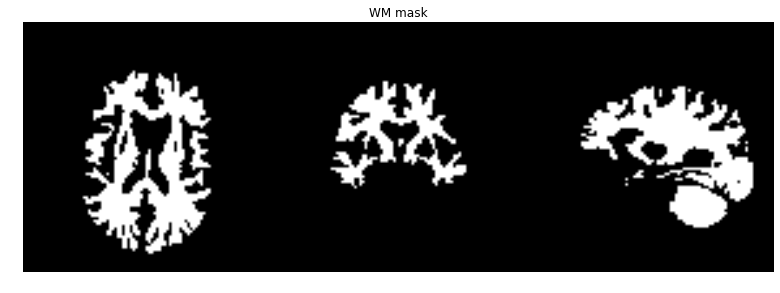

In [34]:
# Very crude WM mask
mask = np.logical_and(dwi_sig>np.percentile(dwi_sig, 90), brain_mask).astype(int)

fig = plt.figure(figsize=(14,4))
d,clip = ip_utils.prep_brain(nib.Nifti1Image(mask,affine))
ip_utils.plot_brain(ip_utils.three_axis(d, sl=sl), cmap='gray', clip=clip, fig=fig)
plt.title('WM mask')

# SNR maps for b=7k
The b=7k b0 image has higher signal magnitude than b0 images from lower b-values, despite the longer TE. It also has better tissue contrast. Both of these are due to the fact that the longer TE of the high b-value scans necessitates a longer TR. For the Stanford protocol, the TRs are short enough that small changes can have a substantial effect on signal levels.

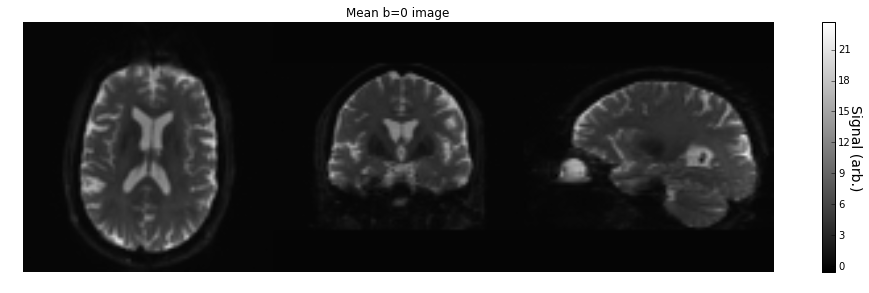

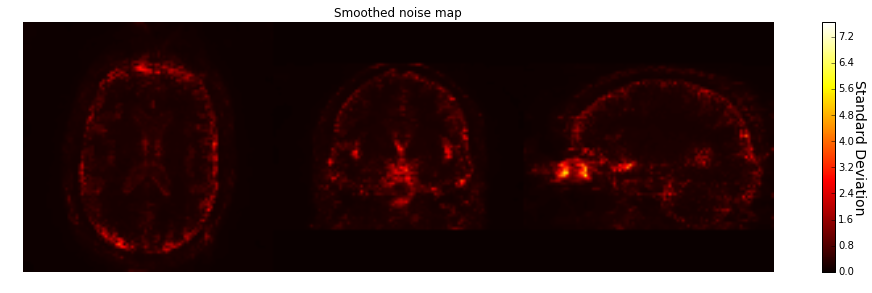

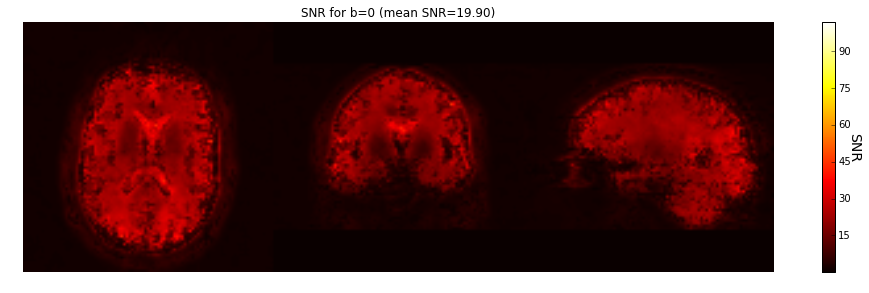

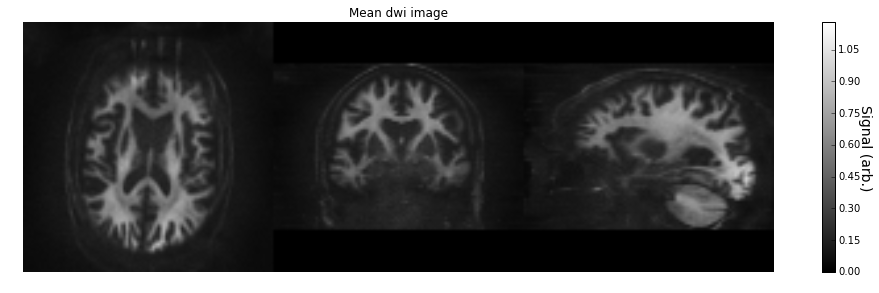

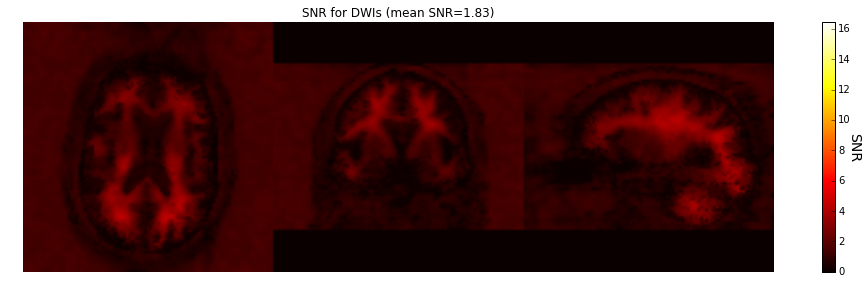

In [ ]:
snr_mean = {}
snr_mean[7] = show_snr_maps('/scratch/upitt/s002_abs/b7k_dwi_ec', mask)

# SNR maps for b=5k

In [ ]:
snr_mean[5] = show_snr_maps('/scratch/upitt/s002_abs/b5k_dwi_ec', mask)

# SNR maps for b=3k

In [ ]:
snr_mean[3] = show_snr_maps('/scratch/upitt/s002_abs/b3k_dwi_ec', mask)

# SNR maps for b=1k

In [ ]:
snr_mean[1] = show_snr_maps('/scratch/upitt/s002_abs/b1k_dwi_ec', mask)

In [ ]:
for b in sorted(snr_mean):
    print "b%0.0fK: b0 SNR=%5.2f, dwi SNR=%5.2f" % ((b,)+snr_mean[b])